# Apache Kafka Streaming Analytics
### One Broker Setup
<br>
<hr>

#### Component: Consumer
In this notebook Apache Kafka is going to be used and analyzed with reference to the streaming performance using the twitter dataset.

In this case, we are going to use only one **Kafka Broker** that streams the data to the **Kafka Consumer**.

In [ ]:
# Install the Python Client for Apache Kafka
!pip install confluent-kafka

In [1]:
# Load dependencies and set constants
import matplotlib.pyplot as plt
import platform, socket, json, psutil, logging, multiprocessing

from time import time, perf_counter
from confluent_kafka import Consumer, KafkaError
from statistics import mean

DATASET_SIZE_IN_MB = 10
DATASET_SIZE_IN_MSGS = 14485

CONSUMER_GROUP_ID = "twitter-consumers"
KAFKA_TOPIC_TWITTER = "twitter-stream"

def get_system_info():
    """ Returns system information as JSON. """
    try:
        info = {}
        info['platform'] = platform.system()
        info['platform-version'] = platform.version()
        info['hostname'] = socket.gethostname()
        info['ram'] = str(round(psutil.virtual_memory().total / (1024.0 **3))) + " GB"
        info['vCPUs'] = multiprocessing.cpu_count()
        info['architecture'] = platform.machine()

        return json.dumps(info, indent=4)
    except Exception as e:
        logging.exception(e)
        
def assignment_report(consumer: Consumer, assignments: list):
    """ Callback for printing the assigned topic partitions of the consumer """
    for assignment in assignments:
        print("Consumer got assigned partition {0} for topic {1}.".format(assignment.partition, assignment.topic))
    print("\n")
    
def get_kafka_stats(json_stats_bytes: bytes):
    """ Callback for the Apache Kafka Consumer Configuration which 
    requests performance metrics / statistics from Kafka. 
    
    :param json_stats_bytes: The JSON statistics data in bytes
    """
    # Decode the bytes into a python dictionary representing the JSON
    stats = json.loads(json_stats_bytes)
    # TODO: Check if we can actually use those statistics. If so, uncomment them in the consumer config

### Reminder: Running Kafka Architecture required
The following cells assume a running Apache Kafka Environment.
<hr>
<br>

Furthermore, as we are using the **Consumer** component here, we have to make sure to start the consumer first before we start the Producer to ensure a performance measurement under realistic circumstances.

In [2]:
# Print system information
print(get_system_info())

# Create Kafka Consumer
consumer_config = {
    "bootstrap.servers": "localhost:9092",
    "group.id": CONSUMER_GROUP_ID,
    "client.id": "client-1",
#     "stats_cb": get_kafka_stats,
#     "statistics.interval.ms": 20,
#     'api.version.request': True,
    "enable.auto.commit": True,
    "session.timeout.ms": 6000,
    "default.topic.config": {"auto.offset.reset": "smallest"}
}
c = Consumer(consumer_config)

{
    "platform": "Linux",
    "platform-version": "#80-Ubuntu SMP Mon Apr 12 17:35:00 UTC 2021",
    "hostname": "apache-kafka-master",
    "ram": "9 GB",
    "vCPUs": 2,
    "architecture": "x86_64"
}


In [3]:
def visualize_results(latency_results: list, throughputs_mbs_per_sec:list, throughputs_msgs_per_sec: list, mb_per_exec: int):
    """ Visualizes the benchmark results in plots.
    
    :param latency_results: list of lists, each containing the latencies of a specific benchmark execution
    :param throughputs_mbs_per_sec: Throughput results, given in MBs / second
    :param throughputs_msgs_per_sec: Throughput results, given in Messages / second
    :param mb_per_exec: Amount of data in MB received per execution
    """
    # Latencies
    for exec_count, latencies in enumerate(latency_results):
        latencies.sort()
        
        # Percentiles
        p50_idx = int(len(latencies) * 50.0 / 100.0)
        p75_idx = int(len(latencies) * 75.0 / 100.0)
        p90_idx = int(len(latencies) * 90.0 / 100.0)
        p95_idx = int(len(latencies) * 95.0 / 100.0)
        p99_idx = int(len(latencies) * 99.0 / 100.0)
        
        p50 = latencies[p50_idx]
        p75 = latencies[p75_idx]
        p90 = latencies[p90_idx]
        p95 = latencies[p95_idx]
        p99 = latencies[p99_idx]
        
        fig = plt.figure(figsize=(12, 6), dpi=90)
        ax = plt.axes()
        
        # Plot the ascendingly sorted latencies
        xs = [i for i in range(1, len(latencies)+1)]
        ys = latencies
        ax.plot(xs, ys)
        
        # Set Percentile labels and visualize them by dashed lines
        ax.set_xticks([p50_idx, p75_idx, p90_idx, p95_idx, p99_idx])
        ax.set_xticklabels(["50%", "75%", "90%", "95%", "99%"])
        ax.grid(axis="x", color="green", alpha=.4, linewidth=2, linestyle=":")
        
        ax.set_ylabel("Latency (ms)", fontsize=12)
        ax.set_title("Benchmark {0}: Latencies ({1} MB)".format(exec_count+1, mb_per_exec), fontsize=15)
        
        fig.show()
    
    # Min, Max, Avg MB/s and Messages/s
    max_mbs_per_sec, min_mbs_per_sec, avg_mbs_per_sec = max(throughputs_mbs_per_sec), \
                                                        min(throughputs_mbs_per_sec), \
                                                        mean(throughputs_mbs_per_sec)
    
    max_msgs_per_sec, min_msgs_per_sec, avg_msgs_per_sec = max(throughputs_msgs_per_sec), \
                                                           min(throughputs_msgs_per_sec), \
                                                           mean(throughputs_msgs_per_sec)
    
    print("MB/s: | Max: {0} MB/s | Min: {1} MB/s | Avg: {2} MB/s"
          .format(max_mbs_per_sec, min_mbs_per_sec, avg_mbs_per_sec))
    
    print("Messages/s: | Max: {0} Messages/s | Min: {1} Messages/s | Avg: {2} Messages/s"
          .format(max_msgs_per_sec, min_msgs_per_sec, avg_msgs_per_sec))

    # Plot Max, Min, Avg MB/s
    fig = plt.figure(figsize=(10, 6), dpi=80)
    plt.bar(0, max_mbs_per_sec, width=1, color='navy')
    plt.bar(1, avg_mbs_per_sec, width=1, color='darkcyan')
    plt.bar(2, min_mbs_per_sec, width=1, color='skyblue')

    plt.tick_params(labelleft=True, labelbottom=False)
    plt.legend(["Maximum MB/s", "Average MB/s", "Minimum MB/s"], prop = {'size': 12}, bbox_to_anchor=(1.05, 0.8))
    plt.title("Summarization of Throughput in MB/s", fontsize=14, pad=12)
    plt.show() 
    
    # Plot Max, Min, Avg Messages/s
    fig = plt.figure(figsize=(10, 6), dpi=80)
    plt.bar(0, max_msgs_per_sec, width=1, color='navy')
    plt.bar(1, avg_msgs_per_sec, width=1, color='darkcyan')
    plt.bar(2, min_msgs_per_sec, width=1, color='skyblue')

    plt.tick_params(labelleft=True, labelbottom=False)
    plt.legend(["Maximum MSG/s", "Average MSG/s", "Minimum MSG/s"], prop = {'size': 12}, bbox_to_anchor=(1.05, 0.8))
    plt.title("Summarization of Throughput in Messages/s", fontsize=14, pad=12)
    plt.show() 

def benchmark(mb_per_exec: int = 1000, exec_count: int = 10):
    """ Executes a latency benchmark procedure, e.g. the elapsed time between storing 
        a message in the logs at the Broker side (LogAppendTime) and receiving / consuming it 
        on the Consumer side. To get meaningful results, the benchmark procedure is repeated
        exec_count times.
        Default is ~ 1GB per execution, while executing 10 times.

        :param mb_per_exec: Amount of data to expect (sent by the producer) per execution, given in MB.
                            As the dataset is 10 MB large, mb_per_exec % 10 = 0 should be true for the
                            given argument.
        :param exec_count: Amount of times to repeat the benchmark procedure
    """
    print("Executing latency benchmark. Waiting for Producer sending data ...")        
    
    latency_results = []
    throughputs_in_mb = [] # MB/s
    throughputs_in_msgs = [] # Messages/s
    
    total_messages = int(DATASET_SIZE_IN_MSGS * (mb_per_exec / DATASET_SIZE_IN_MB))
        
    c.subscribe([KAFKA_TOPIC_TWITTER], on_assign=assignment_report)
    for execution in range(exec_count):
        msg_counter = 0
        latencies = []
        
        start = None
        while msg_counter < total_messages:
            # Start the timer once the first message was received
            if msg_counter == 1:
                start = perf_counter()
                
            msg = c.poll(0.5)

            if msg is None:
                continue
            elif not msg.error():
                msg_counter += 1
                latency = (time() * 1000) - msg.timestamp()[1]
                latencies.append(latency)
            elif msg.error().code() == KafkaError._PARTITION_EOF:
                print("End of partition reached {}/{}".format(msg.topic(), msg.partition()))
                print("Messages consumed: {}".format(msg_counter))
            else:
                print("Error occured: {}".format(msg.error().str()))
        end = perf_counter()
        
        consume_time = float(end - start)
        megabytes_per_second = mb_per_exec / consume_time
        msgs_per_second = total_messages / consume_time
        
        print("{} Messages in {:.2f} seconds | {} Messages/s"
              .format(total_messages, consume_time, int(total_messages / consume_time)))
        
        # Save results for later visualization
        latency_results.append(latencies)
        throughputs_in_mb.append(megabytes_per_second)
        throughputs_in_msgs.append(msgs_per_second)
        
    print("\n" + "Benchmark procedure finished. Visualizing the results ...")
    visualize_results(latency_results, throughputs_in_mb, throughputs_in_msgs, mb_per_exec)

Executing latency benchmark. Waiting for Producer sending data ...
Consumer got assigned partition 0 for topic twitter-stream.


1448500 Messages in 13.47 seconds | 107547 Messages/s
1448500 Messages in 13.25 seconds | 109335 Messages/s
1448500 Messages in 12.74 seconds | 113680 Messages/s
1448500 Messages in 12.20 seconds | 118769 Messages/s
1448500 Messages in 12.97 seconds | 111671 Messages/s
1448500 Messages in 12.28 seconds | 117942 Messages/s
1448500 Messages in 12.91 seconds | 112159 Messages/s
1448500 Messages in 12.38 seconds | 116974 Messages/s
1448500 Messages in 11.78 seconds | 122991 Messages/s
1448500 Messages in 11.36 seconds | 127453 Messages/s

Benchmark procedure finished. Visualizing the results ...
MB/s: | Max: 87.9902340849937 MB/s | Min: 74.24747479460136 MB/s | Avg: 79.9810636202903 MB/s
Messages/s: | Max: 127453.85407211338 Messages/s | Min: 107547.46723998008 Messages/s | Avg: 115852.57065399051 Messages/s


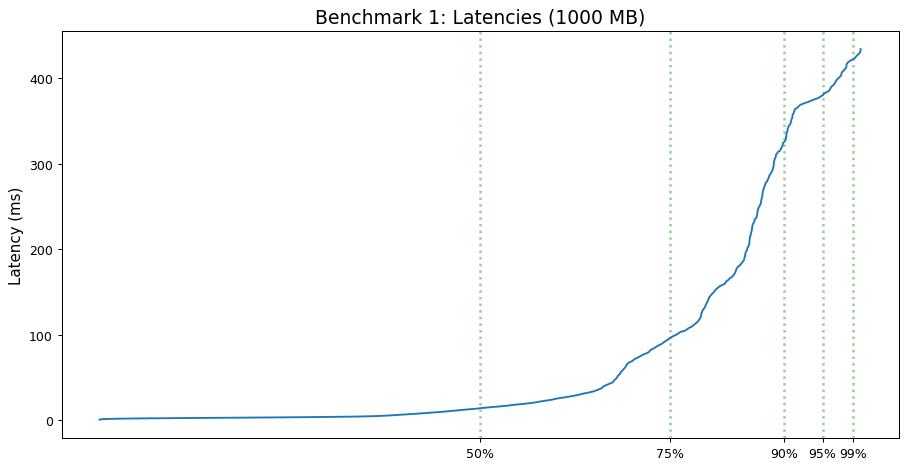

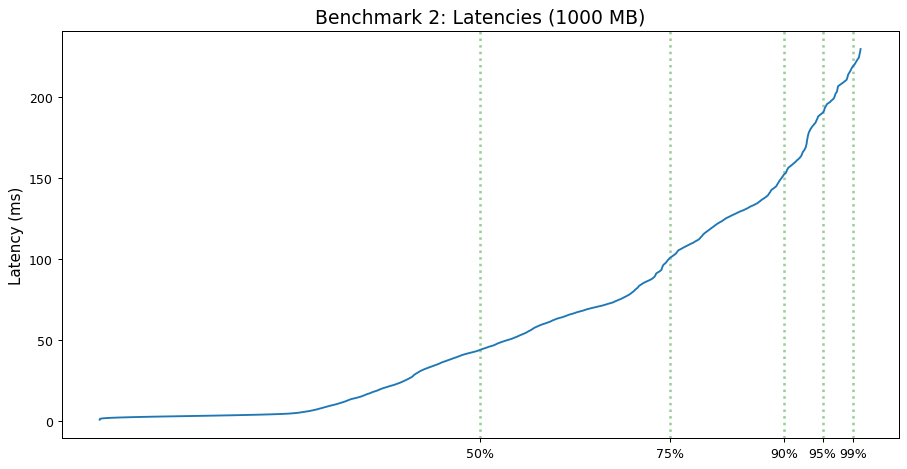

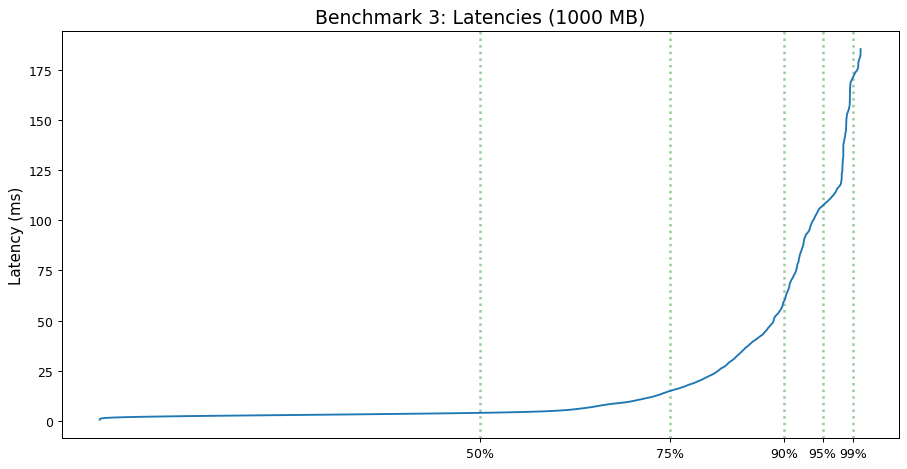

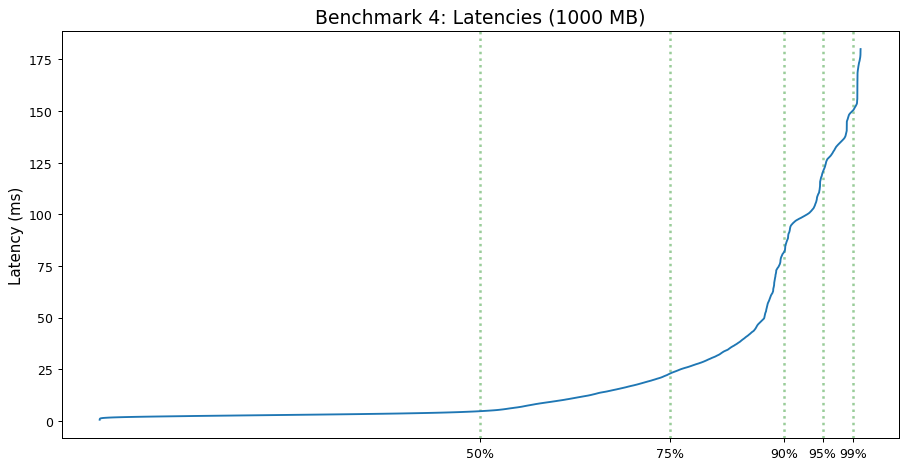

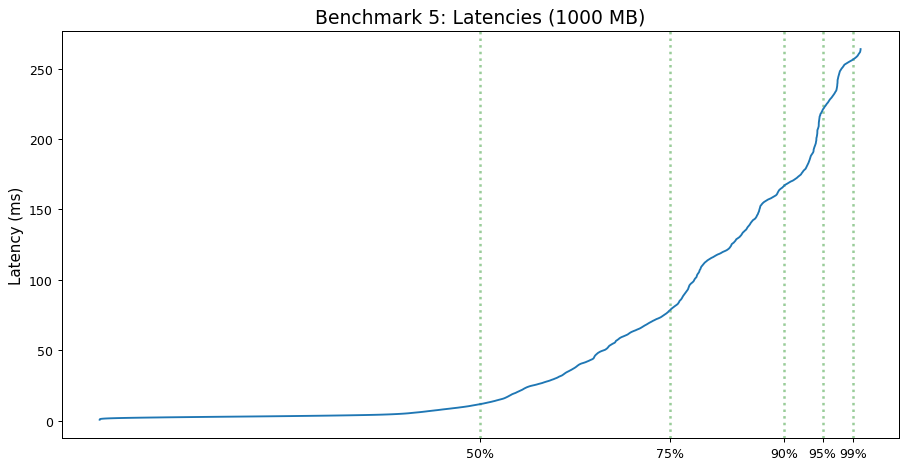

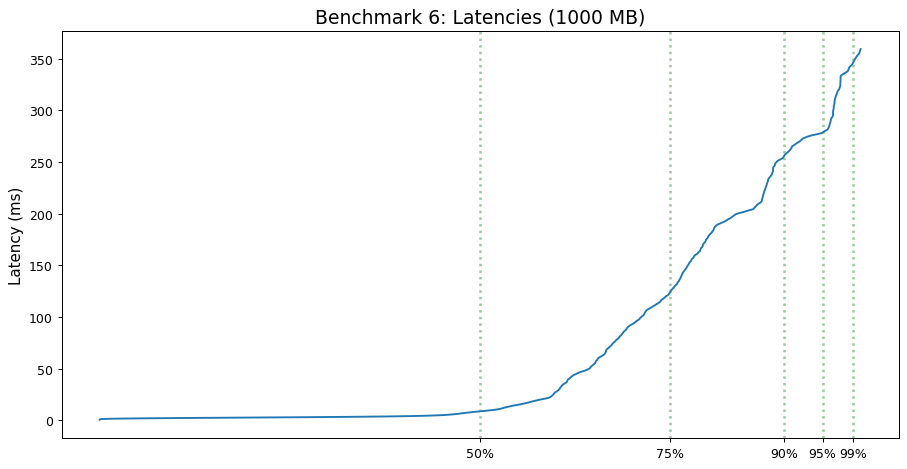

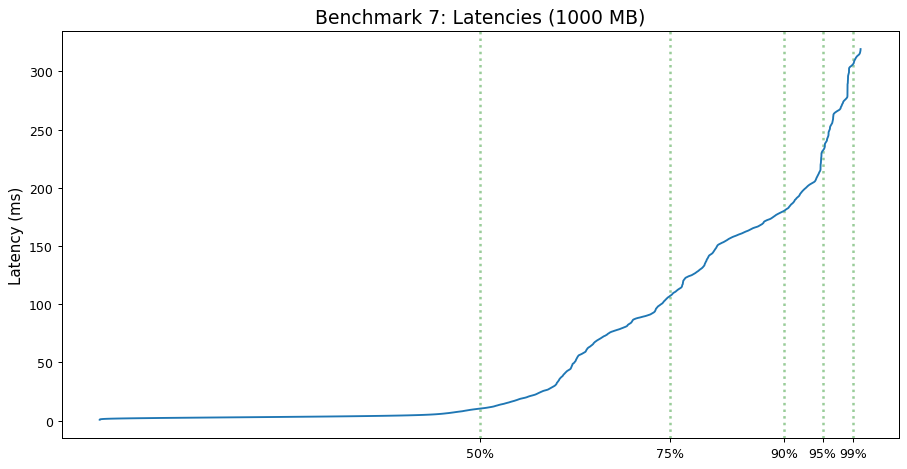

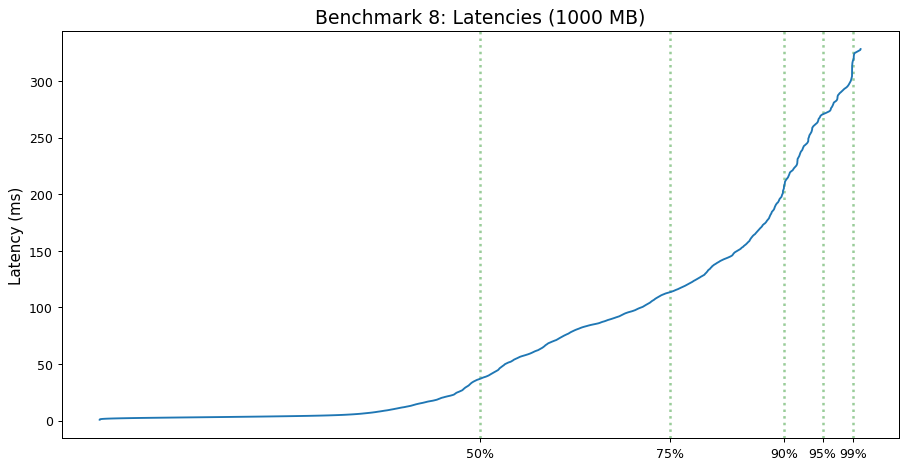

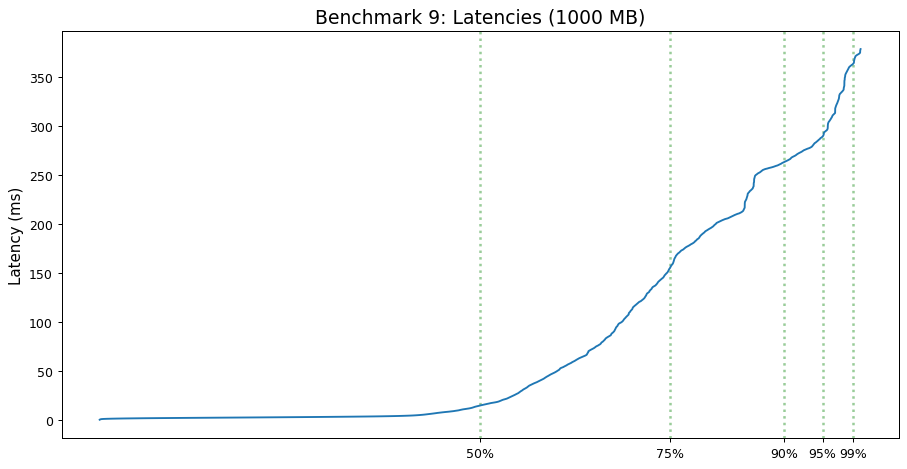

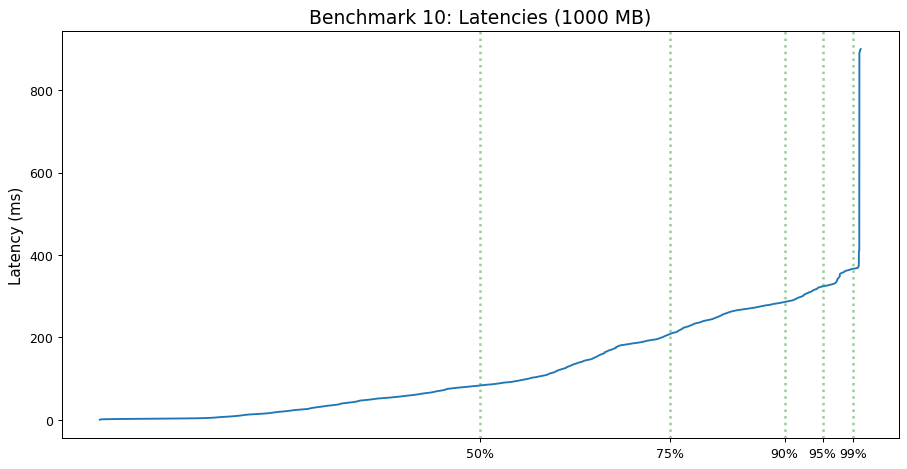

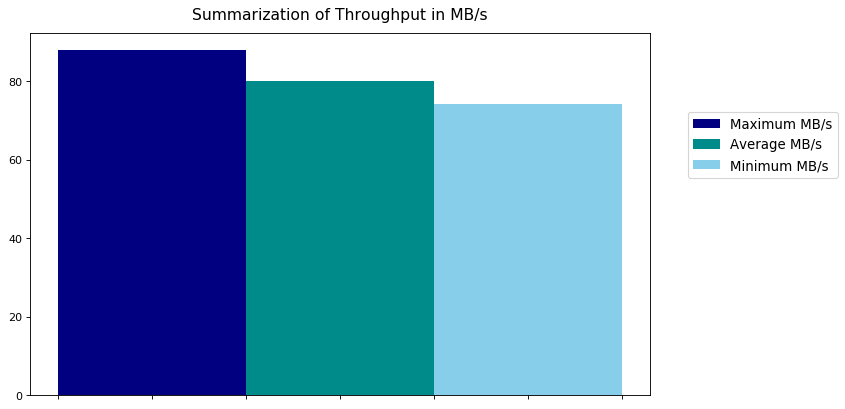

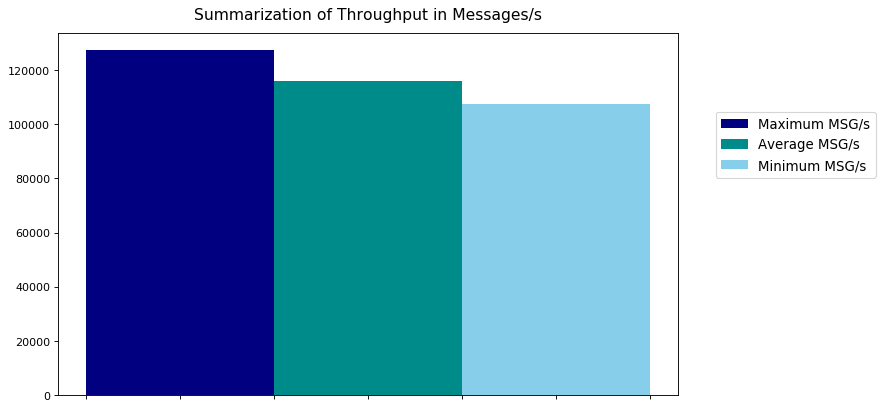

In [4]:
# Execute the benchmark
benchmark(mb_per_exec=1000, exec_count=10)